In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
n = 24983 #users
m = 100 # jokes


In [0]:
#mean square error
def mse(n,m,U,V,S_mat, S_dict, average = False):
    loss = 0
    num_elements = S_mat.nnz
    if not average:
        for (k,v) in S_dict.items():
            loss += (U[k[0],:].dot(V[k[1],:]) - v)**2
    else:
        for (k,v) in S_dict.items():
            loss += (U[k[0]]*V[k[1]] - v)**2      
    return (loss/num_elements)
    
    

In [0]:
def mae(n,m,U,V,S_mat, S_dict, average = False):
    loss = 0
    num_elements = S_mat.nnz
    if not average:
        for (k,v) in S_dict.items():
            loss += np.abs(U[k[0],:].dot(V[k[1],:]) - v)
    else:
        for (k,v) in S_dict.items():
            loss += np.abs(U[k[0]]*V[k[1]] - v)      
    return (loss/num_elements)

In [0]:
#mean abs error
def mae1(n,m,U,V,S_mat,S_dict, average = False):
    loss = 0
    for i in range(n): #n users
        user_i = S_mat.getrow(i)
        N = user_i.size
        sum_user_i = 0
        if not average:
            for j in range(m): #j ratings
                if (i,j) in S_dict:
                    sum_user_i += np.abs(U[i,:].dot(V[j,:]) - S_dict[(i,j)]) #S_mat.todok()[i,j])
        else:
            for j in range(m): # j ratings
                if (i,j) in S_dict:
                    sum_user_i += np.abs(U[i]*V[j] - S_dict[(i,j)]) #- S_mat.todok()[i,j])
        loss += sum_user_i

In [0]:
# import sparse module from SciPy package 
from scipy import sparse
# import uniform module to create random numbers
from scipy.stats import uniform


In [0]:
#Parse to sparse matrix
i_index = []
j_index = []
s_rating = []

user_dict = {}
joke_dict = {}
with open('jester/train.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        token = line.strip().split(',')
        i_index.append(int(token[0])-1)
        j_index.append(int(token[1])-1)
        s_rating.append(float(token[2]))
        if int(token[0])-1 not in user_dict:
            user_dict[int(token[0])-1] = [int(token[1])-1]
        else:
            user_dict[int(token[0])-1].append(int(token[1])-1)
            
        if int(token[1])-1 not in joke_dict:
            joke_dict[int(token[1])-1] = [int(token[0])-1]
        else:
            joke_dict[int(token[1])-1].append(int(token[0])-1)        


In [0]:
S_mat = sparse.coo_matrix((s_rating, (i_index, j_index)))


In [0]:
#Parse to sparse matrix (TEST)
i_index = []
j_index = []
s_rating = []

with open('jester/test.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        token = line.strip().split(',')
        i_index.append(int(token[0])-1)
        j_index.append(int(token[1])-1)
        s_rating.append(float(token[2])) 

In [0]:
S_mat_test = sparse.coo_matrix((s_rating, (i_index, j_index)))

In [0]:
import scipy
from scipy.sparse.linalg import svds, eigs

In [0]:
d = [1,2,5,10,20,50]
U, S, VT = svds(S_mat, k=d[1])

In [0]:
#Parse to dictionary
S_dict = {}
with open('jester/train.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        token = line.strip().split(',')
        S_dict[(int(token[0])-1, int(token[1])-1)] = float(token[2])

In [0]:
S_dict_test = {}
with open('jester/test.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        token = line.strip().split(',')
        S_dict_test[(int(token[0])-1, int(token[1])-1)] = float(token[2])

In [0]:
# Method 3: This does not work, as learning rate for jokes and users should be different
# Otherwise the loss will blow up
# Recall that we have almost 25000 users and 100 jokes. 
# One way to fix it is to have different learning rate for U and V
# Another way to fit it is to update at EVERY point in the dataset so we have A LOT OF updates

lambda_ = 0.001
lr = 0.01
d = 2
U = np.random.rand(n,d)
V = np.random.rand(m,d)
loss = []
for iter in range(5):
    #fix u update v
    for j in range(m): #m jokes m = 100
        gradvj = 0
        for user_idx in joke_dict[j]:
            gradvj += (U[user_idx,:].dot(V[j,:]) - S_dict[(user_idx, j)])*U[user_idx,:] 
        gradvj += lambda_ *V[j,:]
        V[j,:] -= lr * gradvj
    
    
    #fix v update u
    for i in range(n): #n users n = 24983
        gradui = 0
        for joke_idx in user_dict[i]:
            gradui += (U[i,:].dot(V[joke_idx,:]) - S_dict[(i, joke_idx)])*V[joke_idx,:] 
        gradui += lambda_ *U[i,:]
        U[i,:] -= lr * gradui
    
    loss.append(mse(n,m,U,V,S_mat, S_dict,average = False))
    print("mse loss:", loss[iter])
  
  
  #see that the loss blows up to inf below

mse loss: 369715737297.4861
mse loss: 6.2374741571921744e+75


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  


mse loss: inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


KeyboardInterrupt: ignored

In [0]:
# We will try different learning rate here. Hopefully, the training loss will decrease
# It decreases but at a very slow rate
lambda_ = 0.001
lr_v = 0.001
lr_u = lr_v/(25000/100)
d = 2
U = np.random.rand(n,d)
V = np.random.rand(m,d)
loss = []
for iter in range(10):
    #fix u update v
    for j in range(m): #m jokes m = 100
        gradvj = 0
        for user_idx in joke_dict[j]:
            gradvj += (U[user_idx,:].dot(V[j,:]) - S_dict[(user_idx, j)])*U[user_idx,:] 
        gradvj += lambda_ *V[j,:]
        V[j,:] -= lr_v * gradvj
    
    
    #fix v update u
    for i in range(n): #n users n = 24983
        gradui = 0
        for joke_idx in user_dict[i]:
            gradui += (U[i,:].dot(V[joke_idx,:]) - S_dict[(i, joke_idx)])*V[joke_idx,:] 
        gradui += lambda_ *U[i,:]
        U[i,:] -= lr_u * gradui
    
    loss.append(mse(n,m,U,V,S_mat, S_dict,average = False))
    print("mse loss:", loss[iter])
  

mse loss: 90.79267127864394
mse loss: 502.7719363774506
mse loss: 96.29313864498629
mse loss: 26.9224752560586
mse loss: 25.56643415362606
mse loss: 25.495813515080574
mse loss: 25.461319536156726
mse loss: 25.429872998795673
mse loss: 25.398841925653855
mse loss: 25.367822109440294


In [0]:
# We will try to update every joke and users (like Pascal suggests)
# E.g: for each user i
#          for each joke j of that user
#              update the vector of user i 
# Yayyy, it is decreasing, Pascal is awesome
# See if we can get to mse train around 16 
# Yes, we do get to 16 
lambda_ = 0.001
lr = 0.001
lr_v = 0.001
lr_u = 0.01/(25000/100)
d = 2
#U = np.random.rand(n,d)
#V = np.random.rand(m,d)
loss = []
for iter in range(20):
    #fix u update v
    for j in range(m): #m jokes m = 100
        for user_idx in joke_dict[j]:
            V[j,:] -= lr*((U[user_idx,:].dot(V[j,:]) - S_dict[(user_idx, j)])*U[user_idx,:] + lambda_*V[j,:])   
    
    #fix v update u
    for i in range(n): #n users n = 24983
        for joke_idx in user_dict[i]:
            U[i,:] -= lr*((U[i,:].dot(V[joke_idx,:]) - S_dict[(i, joke_idx)])*V[joke_idx,:] + lambda_*U[i,:])
    
    loss.append(mse(n,m,U,V,S_mat, S_dict,average = False))
    print("mse loss:", loss[iter])

mse loss: 17.007361550597203
mse loss: 16.916132924378413
mse loss: 16.852868779140632
mse loss: 16.807814657978604
mse loss: 16.774881952982536
mse loss: 16.750211290387576
mse loss: 16.7313100527877
mse loss: 16.71653315595992
mse loss: 16.704770217578435
mse loss: 16.6952550108353
mse loss: 16.68744751217853
mse loss: 16.6809595092653
mse loss: 16.67550675003445
mse loss: 16.670877550019423
mse loss: 16.666911796590664
mse loss: 16.663486645313302
mse loss: 16.660506603808727
mse loss: 16.657896543756838
mse loss: 16.655596700476682
mse loss: 16.653559043468


In [0]:
0.87*11/10

0.9570000000000001

In [0]:
#Method 3:
"""
The second scheme is to update $u_i$ once we go through all the jokes $j$ rated by user $i$. 
The update is solved through least square, either through ``back-slash'' in \texttt{MATLAB}, or \texttt{np.linalg.solve}, or \texttt{cvxpy}.
This method has less frequent updates, more computationally expensive, but can leverage some stable $Ax=b$ solvers. 
"""

lambda_ = 0.001
lr = 0.001
d = 50
U = np.random.randn(n,d)
V = np.random.randn(m,d)
loss = []
for iter in range(50):
    #fix u update v
    for j in range(m): #m jokes
        U_joke_j = U[joke_dict[j],:]
        R_joke_j = []
        for user_idx in joke_dict[j]:
            R_joke_j.append(S_dict[(user_idx,j)])
        R_joke_j = np.array(R_joke_j)
        A = U_joke_j.T.dot(U_joke_j) + lambda_*np.eye(d) 
        b = U_joke_j.T.dot(R_joke_j)
        V[j,:] = np.linalg.solve(A,b)
    
    
    #fix v update u
    for i in range(n): #n users
        V_user_i = V[user_dict[i],:]
        R_joke_i = []
        for joke_idx in user_dict[i]:
            R_joke_i.append(S_dict[(i,joke_idx)])
        R_joke_i = np.array(R_joke_i)
        A = V_user_i.T.dot(V_user_i) + lambda_*np.eye(d)
        b = V_user_i.T.dot(R_joke_i)
        U[i,:] = np.linalg.solve(A,b)
    
    #loss.append(mse(n,m,U,V,S_mat, S_dict,average = False))
    print("mse train loss:", mse(n,m,U,V,S_mat, S_dict, average = 0))
    print("mae train loss:", mae(n,m,U,V,S_mat, S_dict, average = 0))

    print("mse test loss:", mse(n,m,U,V,S_mat_test, S_dict_test, average = 0))
    print("mae test loss:", mae(n,m,U,V,S_mat_test, S_dict_test, average = 0))

mse train loss: 0.5040337535148348
mae train loss: 0.39250699012798224
mse test loss: 79.5884305811604
mae test loss: 6.568070098551902
mse train loss: 0.46888482765191786
mae train loss: 0.37465996688452485
mse test loss: 78.4804289583015
mae test loss: 6.515525015393599
mse train loss: 0.439155476262745
mae train loss: 0.35912577852411787
mse test loss: 77.63721495476163
mae test loss: 6.4738537701910746
mse train loss: 0.4136429668771132
mae train loss: 0.3454539046446195
mse test loss: 77.00183053509754
mae test loss: 6.440941431317391


KeyboardInterrupt: ignored

In [0]:
S_mat.getrow(0).toarray()[S_mat.getrow(0).toarray().nonzero()]

array([ 8.79, -7.52, -8.5 ,  4.17, -4.76,  8.45, -7.52, -7.43, -9.81,
       -9.37, -9.81, -8.5 ,  7.82,  7.82,  5.05,  4.95, -8.11, -9.03,
       -9.08, -6.26,  3.79,  3.93, -8.69,  3.2 ,  0.92,  2.82, -8.64,
        8.59,  3.59, -6.84, -9.03, -9.42,  2.82])

In [0]:
(1,2) in S_dict

True

In [0]:
len(S_dict)

904699

In [0]:
# Method 1:
U = np.ones(n)
#Predict V
V = np.zeros(m)
for j in range(m):
    if S_mat.getcol(j).nnz == 0:
        V[j] = 0
    else:
        V[j] = S_mat.getcol(j).sum()/S_mat.getcol(j).nnz
#print("MSE is: ", mse(n,m,U,V,S_mat, S_dict,average = True))
#print("MAE is: ", mae(n,m,U,V,S_mat, S_dict))

In [0]:
print("mse train loss:", mse(n,m,U,V,S_mat, S_dict, average = 1))
print("mae train loss:", mae(n,m,U,V,S_mat, S_dict, average = 1))

print("mse test loss:", mse(n,m,U,V,S_mat_test, S_dict_test, average = 1))
print("mae test loss:", mae(n,m,U,V,S_mat_test, S_dict_test, average = 1))

mse train loss: 24.870775408352657
mae train loss: 4.114385496106998
mse test loss: 24.867462528492833
mae test loss: 4.113832606397694


In [0]:
print("MAE is: ", mae(n,m,U,V,S_mat, S_dict, average = True))

MAE is:  None


In [0]:
# Method 2
d = [1]
for e in d:
    U, S, VT = svds(S_mat, k=e)
    print("SVD {} components".format(e))
    U = U*S
    print("mse train loss:", mse(n,m,U,VT.T,S_mat, S_dict, average = 1))
    print("mae train loss:", mae(n,m,U,VT.T,S_mat, S_dict, average = 1))

    print("mse test loss:", mse(n,m,U,VT.T,S_mat_test, S_dict_test, average = 1))
    print("mae test loss:", mae(n,m,U,VT.T,S_mat_test, S_dict_test, average = 1))


SVD 1 components
mse train loss: [22.59066145]
mae train loss: [3.96503648]
mse test loss: [23.14808079]
mae test loss: [4.01834341]


In [0]:
VT.shape

(5, 100)

In [0]:
U.shape

(24983, 5)

In [0]:
S.shape

(5,)

In [0]:
U.dot(np.diag(S)).dot(VT).shape

(24983, 100)

In [0]:
(U*S).shape

(24983, 2)

In [0]:
VT.shape

(2, 100)

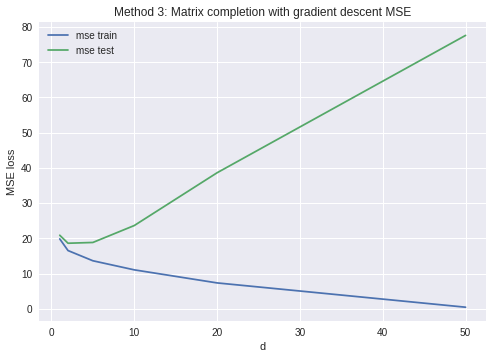

In [0]:
# Method 3
msetrain = [19.83, 16.52, 13.62, 11.04,7.33,0.43]
maetrain = [3.53, 3.18, 2.83, 2.52, 1.99, 0.359]
msetest = [20.87, 18.60, 18.82, 23.63, 38.62, 77.63]
maetest = [3.62, 3.37, 3.32, 3.64, 4.63, 6.41]
d = [1,2,5,10,20,50]
plt.plot(d,msetrain, label = "mse train")
#plt.plot(d,maetrain, label = "mae train")
plt.plot(d,msetest, label = "mse test")
#plt.plot(d,maetest, label = "mae test")
plt.legend()
plt.title("Method 3: Matrix completion with gradient descent MSE")
plt.xlabel("d")
plt.ylabel("MSE loss")
plt.show()

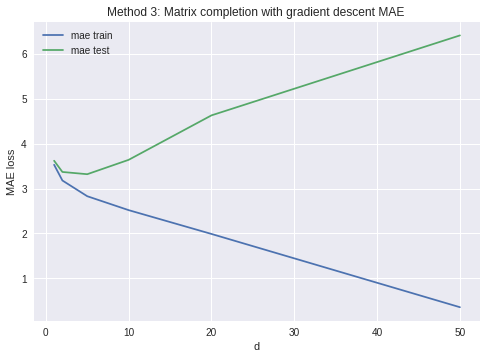

In [0]:
# Method 3
msetrain = [19.83, 16.52, 13.62, 11.04,7.33,0.43]
maetrain = [3.53, 3.18, 2.83, 2.52, 1.99, 0.359]
msetest = [20.87, 18.60, 18.82, 23.63, 38.62, 77.63]
maetest = [3.62, 3.37, 3.32, 3.64, 4.63, 6.41]
d = [1,2,5,10,20,50]
#plt.plot(d,msetrain, label = "mse train")
plt.plot(d,maetrain, label = "mae train")
#plt.plot(d,msetest, label = "mse test")
plt.plot(d,maetest, label = "mae test")
plt.legend()
plt.title("Method 3: Matrix completion with gradient descent MAE ")
plt.xlabel("d")
plt.ylabel("MAE loss")
plt.show()

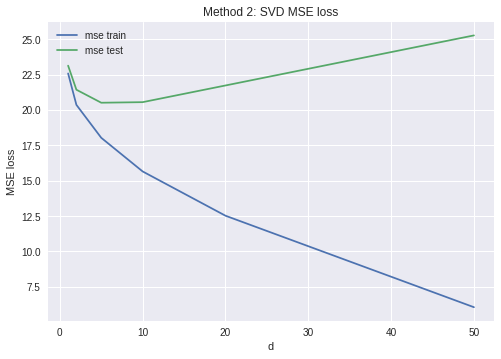

In [0]:
# Method 2
msetrain = [22.59, 20.37, 18.04, 15.66, 12.53, 6.06]
maetrain = [3.96, 3.76, 3.52, 3.24, 2.79, 1.53]
msetest = [23.14, 21.44, 20.52,20.56, 21.74, 25.28]
maetest = [4.01, 3.86, 3.77, 3.76, 3.86, 4.21]
d = [1,2,5,10,20,50]
plt.plot(d,msetrain, label = "mse train")
#plt.plot(d,maetrain, label = "mae train")
plt.plot(d,msetest, label = "mse test")
#plt.plot(d,maetest, label = "mae test")
plt.legend()
plt.title("Method 2: SVD MSE loss")
plt.xlabel("d")
plt.ylabel("MSE loss")
plt.show()

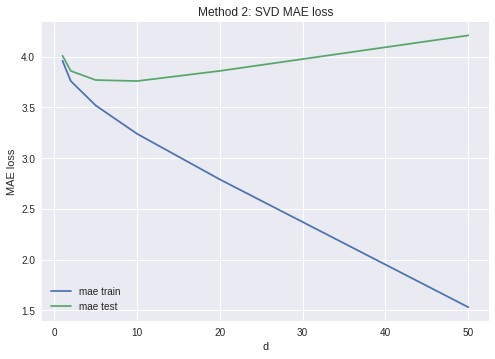

In [0]:
# Method 2
msetrain = [22.59, 20.37, 18.04, 15.66, 12.53, 6.06]
maetrain = [3.96, 3.76, 3.52, 3.24, 2.79, 1.53]
msetest = [23.14, 21.44, 20.52,20.56, 21.74, 25.28]
maetest = [4.01, 3.86, 3.77, 3.76, 3.86, 4.21]
d = [1,2,5,10,20,50]
#plt.plot(d,msetrain, label = "mse train")
plt.plot(d,maetrain, label = "mae train")
#plt.plot(d,msetest, label = "mse test")
plt.plot(d,maetest, label = "mae test")
plt.legend()
plt.title("Method 2: SVD MAE loss")
plt.xlabel("d")
plt.ylabel("MAE loss")
plt.show()